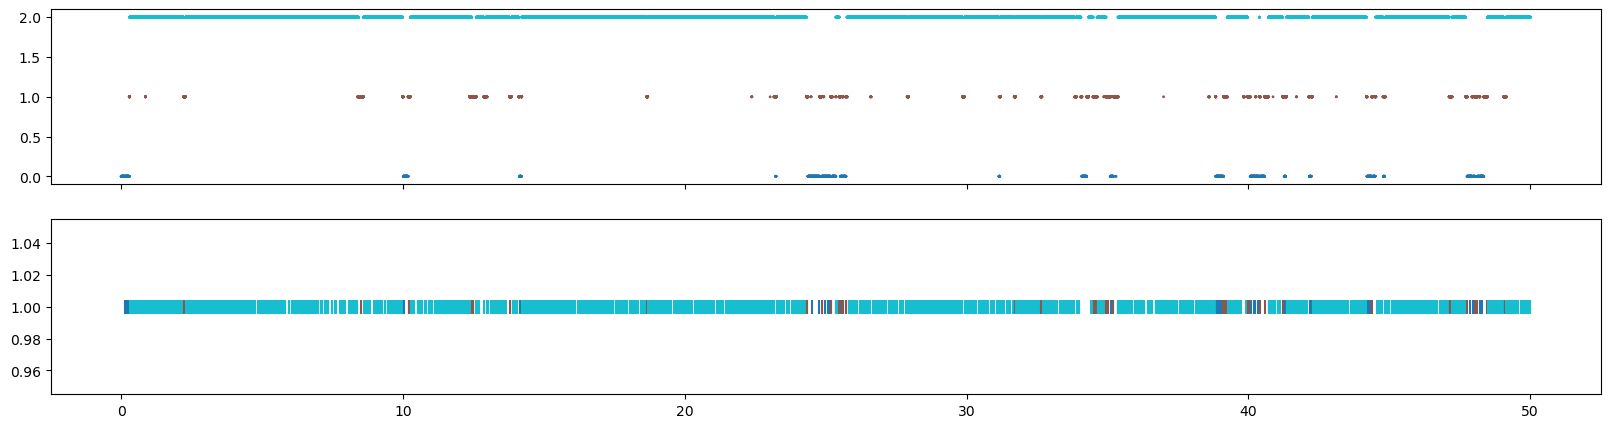

In [1]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt

# acausal posterior should equal marginalized joint distribution

sampling_rate = 1000.0

# Build an HMM instance and set parameters
model = hmm.PoissonHMM(n_components=3)

startprob = np.array([1.0, 0.0, 0.0])
transmat = np.array([[0.99, 0.01, 0.000],
                     [0.010,  0.98, 0.01],
                     [0.000,  0.0010, 0.9990]])

model.startprob_ = startprob
model.transmat_ = transmat
model.lambdas_ = np.array([10.0, 20.0, 40.0])[:, np.newaxis] / sampling_rate

n_time = 50_000
time = np.arange(n_time) / sampling_rate
spikes, latent_states = model.sample(n_time)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 5))
axes[0].scatter(time, latent_states, c=latent_states, cmap="tab10", s=1)

spike_time_ind = np.nonzero(spikes)[0]
axes[1].scatter(time[spike_time_ind], np.ones((len(spike_time_ind),)), c=latent_states[spike_time_ind], cmap="tab10", s=100, marker="|")

In [2]:
from src.estimate_transition import estimate_joint_distribution
from src.hmm import forward, smoother
import scipy.stats

transition_matrix = np.array([[0.98, 0.02, 0.02],
                               [0.02, 0.98, 0.02],
                               [0.02, 0.02, 0.98]])
log_likelihood = scipy.stats.poisson.logpmf(spikes, model.lambdas_.T)
causal_posterior, predictive_distribution, marginal_likelihood = forward(model.startprob_, log_likelihood, transition_matrix)
acausal_posterior = smoother(causal_posterior, predictive_distribution, transition_matrix)

In [3]:
joint_distribution = estimate_joint_distribution(causal_posterior, predictive_distribution, transition_matrix, acausal_posterior)

In [4]:
np.allclose(joint_distribution.sum(axis=-1), acausal_posterior[:-1])

True